## 5. Predecessor
This notebook investigates whether pairwise replay captures predecessor representation.

Jul 10, 2024

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os
import pickle
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [3]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition

from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,behavior_transitions,findXCorrAllDays
from spyglass.shijiegu.decodeHelpers import runSessionNames

[2024-07-10 20:10:57,760][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-07-10 20:10:57,818][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
animal = 'Eliot'
#dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
dates_to_plot = ['20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

In [5]:
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

In [170]:
count, P_replay_all = replay_transitions(animal,dates_to_plot,encoding_set,classifier_param_name)
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
#C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
10_Seq2Session5
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
10_Seq2Session5
12_Seq2Session6
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
10_Seq2Session5
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
02_Seq2Session2
04_Seq2Session3
06_Seq2Session4
08_Seq2Session5
10_Seq2Session6
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
02_Seq2Session1
04_Seq2Session2
06_Seq2Session3
08_Seq2Session4
10_Seq2Session5
12_Seq2Session6


In [186]:
from spyglass.shijiegu.predecessorRepresentation import replay_PR_correlation_day
R={}
for d in dates_to_plot:
    R[d] = replay_PR_correlation_day(animal,d,encoding_set,classifier_param_name,look_back = 20,reverse = True)

In [189]:
for d in dates_to_plot:
    print(np.nanmax(R[d]))

0.17612978121068937
0.22040561867582315
0.15473578882124198
0.24311092104282475
0.2264720784346622
0.0934883452199551
0.12855161446145252
0.14612584577423174


[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.3, '0.3')]

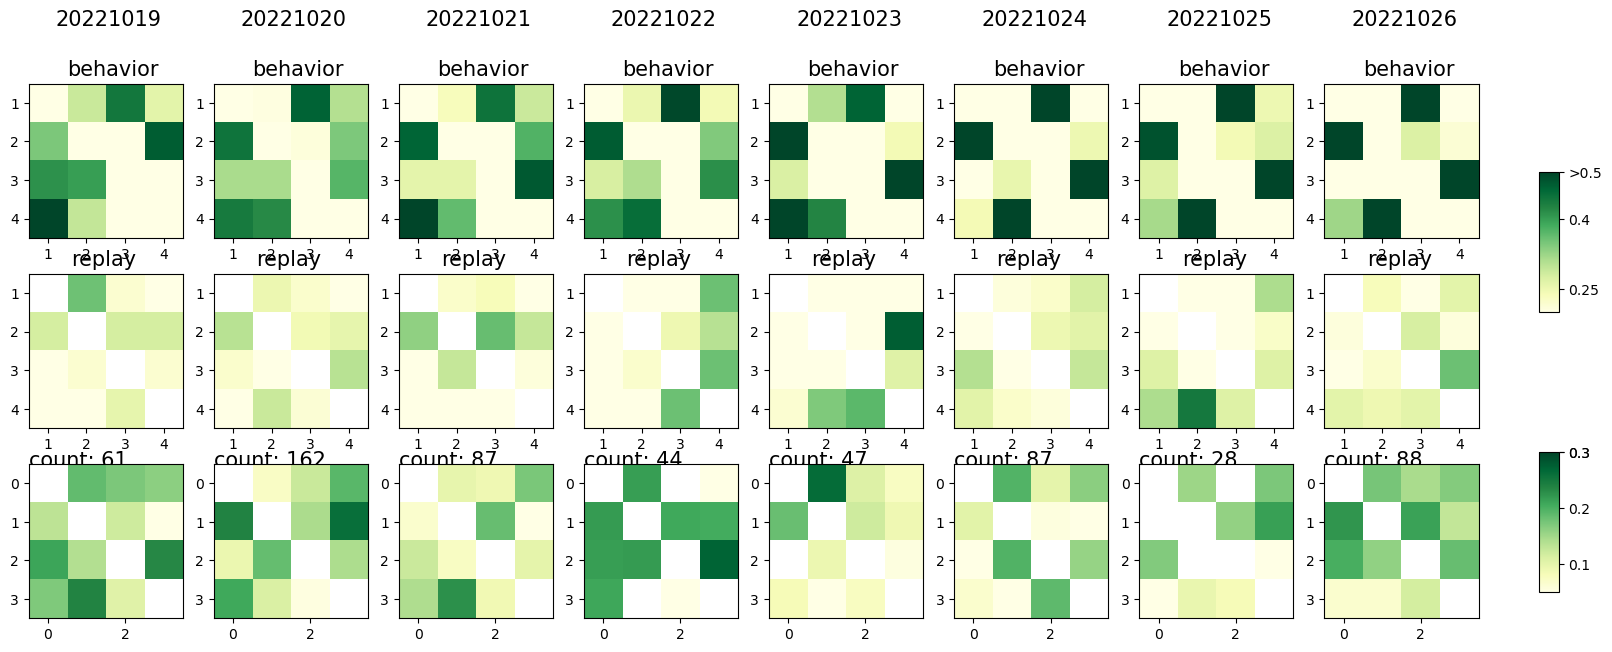

In [191]:
version = 0
fig,axes = plt.subplots(3,len(dates_to_plot),figsize = (20,7))

REPLAY_VMAX = 0.3
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data/np.nansum(replay_data), vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)

    im3 = axes[2,d_ind].imshow(R[d], vmin = -0.2, vmax = 0.3, origin = 'upper',cmap = 'YlGn')

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

In [12]:
d = dates_to_plot[1]
nwb_copy_file_name = animal.lower() + d + '_.nwb'
epoch_names = (TrialChoice & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch_name')

In [13]:
epoch_name = epoch_names[1]

### END

In [14]:
# a session's behavior


In [21]:
table = pd.DataFrame((TrialChoiceReplayTransition & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name':epoch_name,
    'classifier_param_name':classifier_param_name,
    'encoding_set':encoding_set,
}).fetch1('choice_reward_replay_transition'))

In [33]:
totalTrial = len(table.index)-1

In [43]:
table

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.666287e+09,1.0,1.666287e+09,2.0,[],1.0,[],"[[[1666286777.242576, 1666286777.2745762], [16...",[],"[[[], [2, 1]], [[2]]]",[],"[1, 2]",2.0,2.0,4.0,NaN,NaN
2,1.666287e+09,1.0,1.666287e+09,4.0,[],1.0,"[[[1666286788.49457, 1666286788.77857]], [[166...",[],"[[[0]], [[0], []], [[0]], [[0], [3]], [[1, 0],...",[],"[3, 4, 5, 6, 7, 8, 9, 10]",[],4.0,4.0,3.0,2.0,NaN
3,1.666287e+09,1.0,1.666287e+09,3.0,"[(3, 1), (1, 2)]",2.0,"[[[1666286828.4225488, 1666286829.2525482], [1...","[[[1666286846.622539, 1666286846.874539]], [[1...","[[[0, 3], [1], [2]], [[1]], [[3], [0]]]","[[[3]], [[], [2], []], [[3]]]","[11, 12, 13]","[14, 15, 16]",3.0,3.0,1.0,4.0,NaN
4,1.666287e+09,1.0,1.666287e+09,1.0,"[(3, 4), (4, 3)]",1.0,"[[[1666286866.6565282, 1666286866.760528], [16...",[],"[[[], [0], [4]], [[1], [0], []], [[3], [4], [3]]]",[],"[17, 18, 19]",[],1.0,1.0,2.0,3.0,3.0
5,1.666287e+09,1.0,1.666287e+09,2.0,"[(4, 3)]",1.0,"[[[1666286890.4285154, 1666286890.6885154], [1...","[[[1666286905.6045074, 1666286906.080507]]]","[[[2], [0]], [[4], [4], [3]]]",[[[2]]],"[20, 21]",[22],2.0,2.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,1.666289e+09,1.0,1.666289e+09,1.0,[],1.0,[],[],[],[],[],[],1.0,1.0,4.0,1.0,1.0
79,NaN,NaN,1.666289e+09,4.0,[],0.0,[],[],[],[],[],[],4.0,4.0,2.0,1.0,1.0
80,1.666289e+09,1.0,1.666289e+09,2.0,[],1.0,[],[],[],[],[],[],2.0,2.0,1.0,4.0,1.0
81,1.666289e+09,1.0,1.666289e+09,1.0,[],1.0,[],[],[],[],[],[],1.0,1.0,NaN,2.0,1.0


In [35]:
trials = np.array(table.OuterWellIndex)[:-1]

In [ ]:
# behavior: for each trial, keep a rewarded transition count matrix for past LOOK_PAST=10 trials

In [54]:
alpha = 0.1

PR = np.zeros((4,4,totalTrial))

t_ind = 0
for t in table.index[:-1]:
    j = int(table.loc[t].OuterWellIndex) - 1 #zero index in array
    reward = table.loc[t].rewardNum

    # decay PR
    if t_ind > 1:
        PR[:,:,t_ind] = (1-alpha) * PR[:,:,t_ind-1]

    if reward == 2: # rewarded transition
        previous_trial = t-1
        if not np.isin(previous_trial,table.index):
            continue
        i = int(table.loc[previous_trial].OuterWellIndex) - 1 #zero index in array
        PR[i,j,t_ind] += (alpha)

    t_ind += 1

In [60]:
PR[:,:,50]

array([[0.        , 0.05447438, 0.04321633, 0.10096977],
       [0.00343368, 0.        , 0.        , 0.0336339 ],
       [0.        , 0.0280816 , 0.        , 0.01774763],
       [0.09810576, 0.        , 0.08163627, 0.        ]])

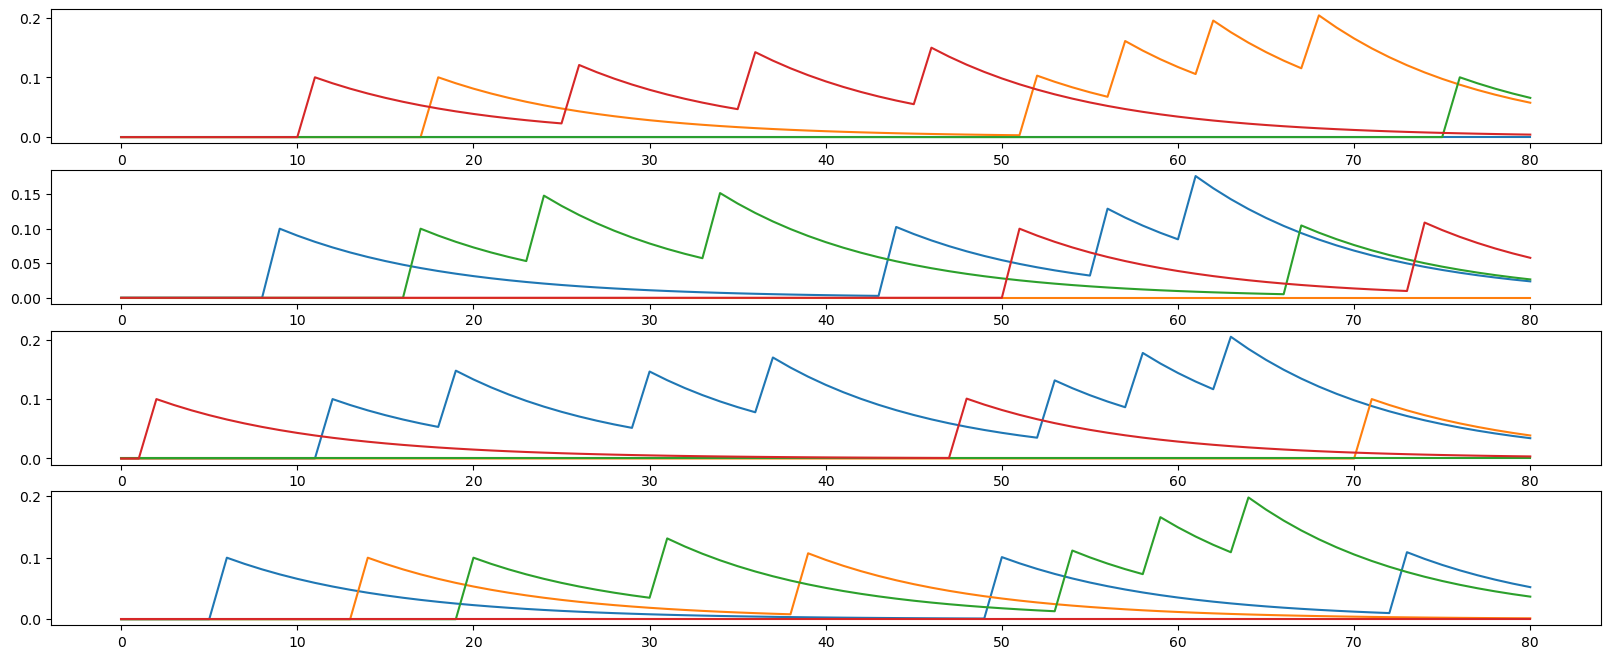

In [59]:
fig,axes = plt.subplots(4,1,figsize = (20,8))
for j in range(4):
    for i in range(4):
        axes[j].plot(PR[i,j,:],color = 'C'+str(i))

In [ ]:
# a session's pairwise replay

In [ ]:
# replay: for each trial, keep a replay count matrix

In [61]:
table.loc[3].replayed_transitions

[(3, 1), (1, 2)]

In [85]:
def transitions_to_matrix(transitions):
    M = np.zeros((4,4))
    for rt in transitions:
        i = int(rt[0]-1)
        j = int(rt[1]-1)
        M[i,j] = M[i,j] + 1
    return M

In [151]:
def normalize_by_row(M):
    for i in range(M.shape[0]):
        rowsum = np.nansum(M[i,:])
        if rowsum != 0:
            M[i,:] = M[i,:]/rowsum
    return M
    
def normalize_by_col(M):
    for i in range(M.shape[1]):
        colsum = np.nansum(M[:,i])
        if colsum != 0:
            M[:,i] = M[:,i]/colsum
    return M

In [101]:
replay = np.zeros((4,4,totalTrial))

t_ind = 0
for t in table.index[:-1]:
    replay_transitions_t = table.loc[t].replayed_transitions
    for rt in replay_transitions_t:
        i = rt[0]-1
        j = rt[1]-1
        replay[i,j,t_ind] += 1

    t_ind += 1

In [82]:
past_reward_transition

{(1, 2), (1, 3), (1, 4), (2, 1), (2, 3), (3, 1), (3, 2), (3, 4), (4, 2)}

In [157]:
from spyglass.shijiegu.predecessorRepresentation import replay_PR_correlation_day, find_past_reward_behavior_transitions

rewarded_transition = np.zeros((4,4,totalTrial))
replay = np.zeros((4,4,totalTrial))

t_ind = 0
replay_trial_ind= []
for t in table.index[:-1]:
    
    past_reward_transition = find_past_reward_behavior_transitions(table,t,LOOK_BACK_NUM = 10)
    replay_transitions_t = table.loc[t].replayed_transitions
    
    rewarded_transition[:,:,t_ind] = transitions_to_matrix(past_reward_transition)
    replay[:,:,t_ind] = transitions_to_matrix(replay_transitions_t)
    if np.sum(replay[:,:,t_ind]) > 0:
        replay_trial_ind.append(t_ind)
    
    rewarded_transition[:,:,t_ind] = normalize_by_col(rewarded_transition[:,:,t_ind])

    t_ind += 1
    
R = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        R[i,j] = np.corrcoef(rewarded_transition[i,j,replay_trial_ind],replay[i,j,replay_trial_ind])[0,1]

trial 1
behavior: []
replay: []

trial 2
behavior: []
replay: []

trial 3
behavior: []
replay: [(3, 1), (1, 2)]

trial 4
behavior: [(4, 3)]
replay: [(3, 4), (4, 3)]

trial 5
behavior: [(4, 3)]
replay: [(4, 3)]

trial 6
behavior: [(4, 3)]
replay: []

trial 7
behavior: [(4, 3)]
replay: []

trial 8
behavior: [(4, 3), (1, 4)]
replay: []

trial 9
behavior: [(4, 3), (1, 4)]
replay: []

trial 10
behavior: [(4, 3), (1, 4)]
replay: []

trial 11
behavior: [(4, 3), (1, 4), (1, 2)]
replay: [(4, 3)]

trial 12
behavior: [(4, 3), (1, 4), (1, 2)]
replay: []

trial 13
behavior: [(4, 3), (1, 4), (1, 2), (4, 1)]
replay: []

trial 14
behavior: [(4, 3), (1, 4), (1, 2), (4, 1), (1, 3)]
replay: []

trial 15
behavior: [(4, 3), (1, 4), (1, 2), (4, 1), (1, 3)]
replay: [(4, 3)]

trial 16
behavior: [(4, 3), (1, 4), (1, 2), (4, 1), (1, 3), (2, 4)]
replay: []

trial 17
behavior: [(4, 3), (1, 4), (1, 2), (4, 1), (1, 3), (2, 4)]
replay: []

trial 18
behavior: [(4, 3), (1, 4), (1, 2), (4, 1), (1, 3), (2, 4)]
replay: [

In [ ]:
%debug

In [99]:
#rewarded_transition

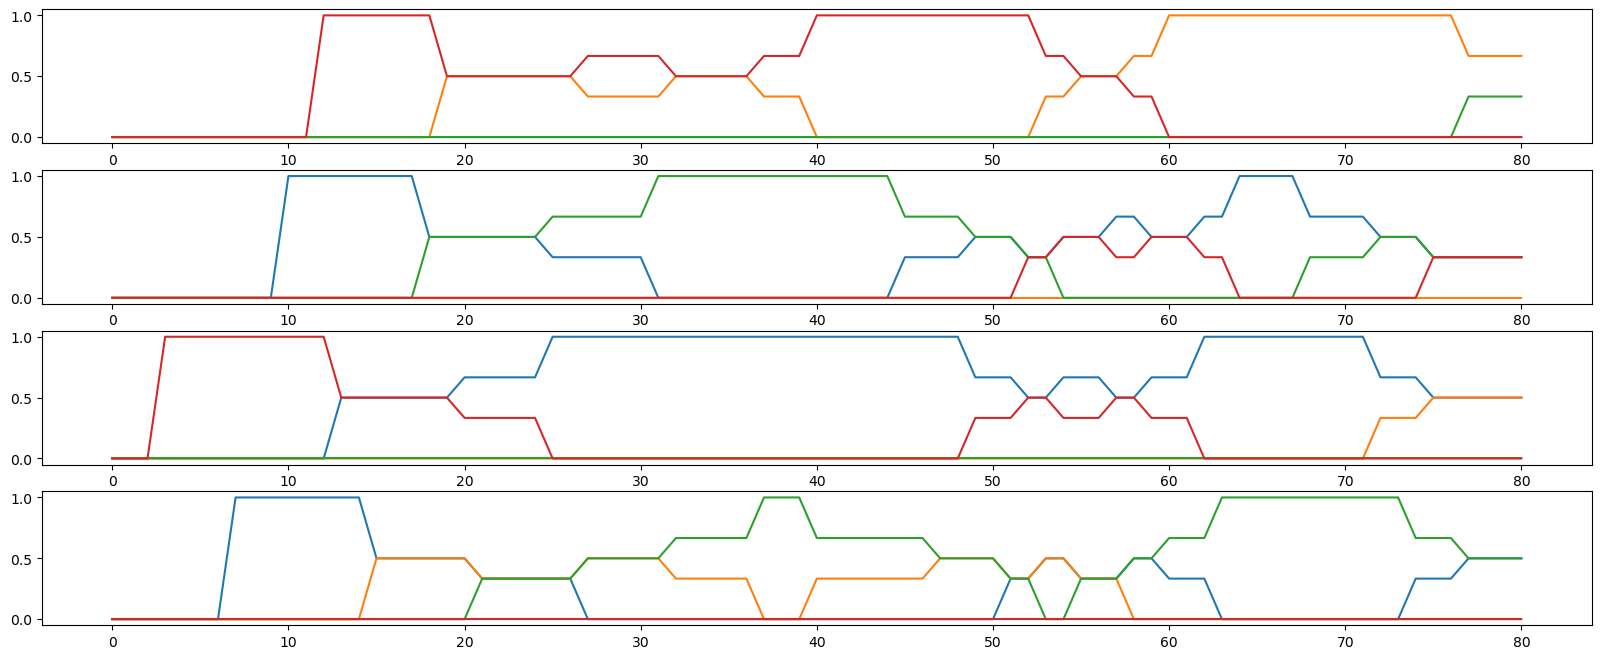

In [158]:
fig,axes = plt.subplots(4,1,figsize = (20,8))
for j in range(4):
    for i in range(4):
        axes[j].plot(rewarded_transition[i,j,:],color = 'C'+str(i))

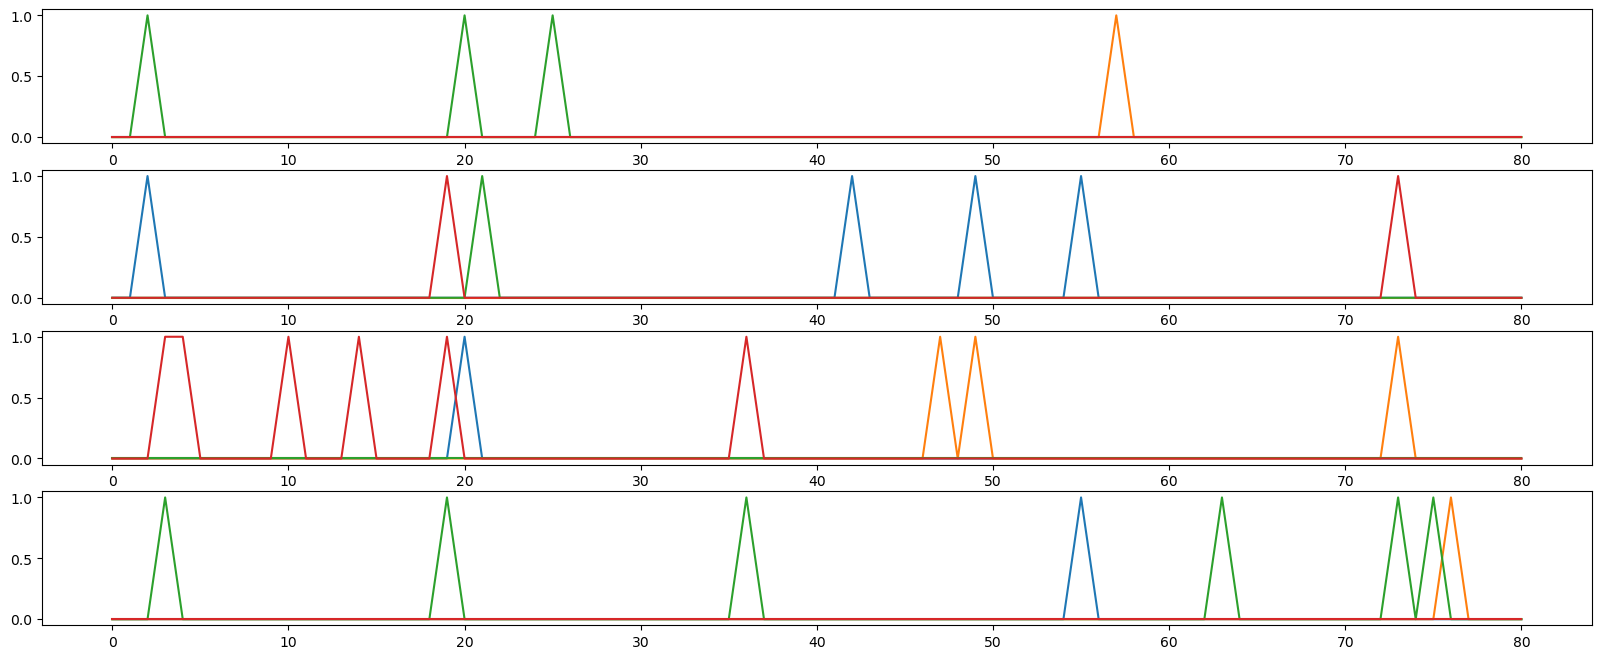

In [98]:
fig,axes = plt.subplots(4,1,figsize = (20,8))
for j in range(4):
    for i in range(4):
        axes[j].plot(replay[i,j,:],color = 'C'+str(i))

In [154]:
R = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        R[i,j] = np.corrcoef(rewarded_transition[i,j,replay_trial_ind],replay[i,j,replay_trial_ind])[0,1]

In [159]:
np.nanmean(R)

0.05965623123447088

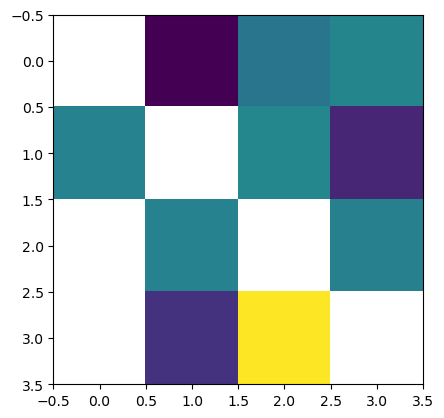

In [156]:
plt.imshow(R)

In [149]:
R1[:16,16:]

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan, -0.10624276,  0.03175269,  0.03175269,  0.08766505,
                nan,  0.02300566, -0.02415966, -0.0750711 ,  0.03175269,
                nan, -0.06111964,         nan,  0.04518841,  0.00960451,
                nan],
       [        nan, -0.05264935,  0.00065383,  0.00065383, -0.05230658,
                nan,  0.06307937, -0.05230658, -0.06078557,  0.00065383,
                nan, -0.04300606,         nan, -0.03675444, -0.26630676,
                nan],
       [        nan, -0.1237111 ,  0.08648475,  0.02761698,  0.02761698,
                nan, -0.15807842,  0.02761698,  0.01402309,  0.02761698,
                nan, -0.10387978,         nan, -0.00258571,  0.14432854,
                nan],
       [        nan, -0.16323505,  0